# 3-Layer Neural Network for Non-linear Regression (NumPy Implementation)

This notebook implements a 3-layer neural network from scratch using only NumPy for non-linear regression. We'll create a synthetic dataset based on a non-linear 3-variable equation and train our neural network to learn this relationship.

Key features:
- Custom implementation of forward and backward propagation
- Manual implementation of gradient descent
- Visualization of training process and results
- 3-layer architecture with non-linear activation functions

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define the function to generate synthetic data
def true_function(X):
    """
    Non-linear function with 3 variables
    X should be a matrix with 3 columns
    """
    return 2 * np.sin(X[:, 0]) + 3 * np.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# Generate synthetic dataset
def generate_data(n_samples=1000):
    # Generate random inputs
    X = np.random.uniform(-2, 2, (n_samples, 3))

    # Calculate true output values
    y_true = true_function(X)

    # Add some noise
    y = y_true + np.random.normal(0, 0.5, n_samples)

    return X, y.reshape(-1, 1)

# Generate training data
X_train, y_train = generate_data(1000)

# Generate test data
X_test, y_test = generate_data(200)

print(f"Training data shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test data shape: X = {X_test.shape}, y = {y_test.shape}")

Training data shape: X = (1000, 3), y = (1000, 1)
Test data shape: X = (200, 3), y = (200, 1)


## Neural Network Implementation

Now we'll implement the core components of our neural network. We'll define:
1. Activation functions (ReLU, sigmoid) and their derivatives
2. Weight initialization function
3. Forward propagation method
4. Backward propagation method with chain rule
5. Training loop with gradient descent optimization

In [2]:
# Activation functions and their derivatives
def relu(Z):
    """ReLU activation function: max(0,Z)"""
    return np.maximum(0, Z)

def relu_derivative(Z):
    """Derivative of ReLU: 1 if Z > 0, else 0"""
    return np.where(Z > 0, 1, 0)

def sigmoid(Z):
    """Sigmoid activation function: 1/(1+e^(-Z))"""
    return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(Z):
    """Derivative of sigmoid: sigmoid(Z) * (1 - sigmoid(Z))"""
    s = sigmoid(Z)
    return s * (1 - s)

def tanh(Z):
    """Hyperbolic tangent activation function"""
    return np.tanh(Z)

def tanh_derivative(Z):
    """Derivative of tanh: 1 - tanh(Z)^2"""
    return 1 - np.power(tanh(Z), 2)

# Weight initialization
def initialize_parameters(layer_dims):
    """
    Initialize weights and biases for all layers

    Arguments:
    layer_dims -- array containing the dimensions of each layer

    Returns:
    parameters -- dictionary containing weights and biases for each layer
    """
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        # He initialization for weights
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

# Forward propagation
def forward_propagation(X, parameters):
    """
    Implement forward propagation for the neural network

    Arguments:
    X -- input data, shape (features, num_examples)
    parameters -- dictionary containing the weights and biases

    Returns:
    A -- output of the last activation function
    cache -- dictionary containing Z and A values for each layer (for backprop)
    """
    cache = {}
    A = X.T  # Transpose X to match weight dimensions (features, examples)
    L = len(parameters) // 2  # Number of layers

    # Forward propagation through hidden layers
    for l in range(1, L):
        cache['A' + str(l-1)] = A
        Z = np.dot(parameters['W' + str(l)], A) + parameters['b' + str(l)]
        cache['Z' + str(l)] = Z

        # Use ReLU for hidden layers
        A = relu(Z)

    # Output layer (linear activation for regression)
    cache['A' + str(L-1)] = A
    Z = np.dot(parameters['W' + str(L)], A) + parameters['b' + str(L)]
    cache['Z' + str(L)] = Z
    A = Z  # Linear activation for regression

    return A, cache

## Backward Propagation and Training

Now we implement the backward propagation algorithm which calculates gradients using the chain rule. The training function brings everything together by:

1. Performing forward propagation to get predictions
2. Calculating the loss
3. Running backward propagation to get gradients
4. Updating the model parameters using gradient descent
5. Tracking the learning progress

In [3]:
# Backward propagation
def backward_propagation(X, Y, parameters, cache):
    """
    Implement backward propagation to compute gradients

    Arguments:
    X -- input data, shape (features, num_examples)
    Y -- true labels, shape (1, num_examples)
    parameters -- dictionary containing weights and biases
    cache -- dictionary containing Z and A values for each layer

    Returns:
    grads -- dictionary containing gradients for each parameter
    """
    m = Y.shape[1]  # Number of examples
    grads = {}
    L = len(parameters) // 2  # Number of layers

    # Initialize gradients for output layer (L)
    # For mean squared error: dL/dA = (A - Y)
    dZ = cache['Z' + str(L)] - Y

    # Get the gradient for the output layer parameters
    grads['dW' + str(L)] = (1/m) * np.dot(dZ, cache['A' + str(L-1)].T)
    grads['db' + str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    # Backpropagate through hidden layers
    for l in reversed(range(1, L)):
        # Current layer's input
        A_prev = cache['A' + str(l-1)]

        # Gradient of the activation
        dA = np.dot(parameters['W' + str(l+1)].T, dZ)

        # Gradient of the linear output
        dZ = dA * relu_derivative(cache['Z' + str(l)])

        # Gradients for weights and bias
        grads['dW' + str(l)] = (1/m) * np.dot(dZ, A_prev.T)
        grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    return grads

# Update parameters
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- dictionary containing weights and biases
    grads -- dictionary containing gradients
    learning_rate -- learning rate for gradient descent

    Returns:
    parameters -- updated parameters
    """
    L = len(parameters) // 2  # Number of layers

    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters

# Training function
def train_neural_network(X, Y, layers_dims, learning_rate=0.01, num_iterations=3000, print_cost=True):
    """
    Train the neural network

    Arguments:
    X -- input data, shape (num_examples, features)
    Y -- true labels, shape (num_examples, 1)
    layers_dims -- array with the dimensions of each layer
    learning_rate -- learning rate for gradient descent
    num_iterations -- number of iterations for training
    print_cost -- whether to print the cost during training

    Returns:
    parameters -- trained parameters
    costs -- list of costs during training
    """
    np.random.seed(42)
    costs = []

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Transpose inputs for internal calculations
    X_T = X.T
    Y_T = Y.T

    # Training loop
    for i in range(num_iterations):
        # Forward propagation
        A, cache = forward_propagation(X, parameters)

        # Compute cost (Mean Squared Error)
        cost = (1/2) * np.mean(np.square(A - Y_T))

        # Backward propagation
        grads = backward_propagation(X_T, Y_T, parameters, cache)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost and store it
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
        if i % 10 == 0:
            costs.append(cost)

    return parameters, costs

## Model Training and Evaluation

Now we'll train our 3-layer neural network and evaluate its performance on the test set. We'll also visualize the training progress and predictions.

Cost after iteration 0: 4.76874498669704
Cost after iteration 100: 1.723052740747307
Cost after iteration 200: 1.339323049462816
Cost after iteration 300: 1.2165924022014705
Cost after iteration 400: 1.120760523998048
Cost after iteration 500: 1.0335223784671284
Cost after iteration 600: 0.9429188499439507
Cost after iteration 700: 0.8482442487285782
Cost after iteration 800: 0.7550144258160546
Cost after iteration 900: 0.6619723009087288
Cost after iteration 1000: 0.575122287353088
Cost after iteration 1100: 0.5046775845706383
Cost after iteration 1200: 0.4506423498935602
Cost after iteration 1300: 0.4090487757796024
Cost after iteration 1400: 0.37816072721217303
Cost after iteration 1500: 0.3546213272834686
Cost after iteration 1600: 0.33551763384377553
Cost after iteration 1700: 0.32015290151947684
Cost after iteration 1800: 0.307031020969727
Cost after iteration 1900: 0.2955003674752222
Cost after iteration 2000: 0.28559053642579263
Cost after iteration 2100: 0.2772204226206772
Cos

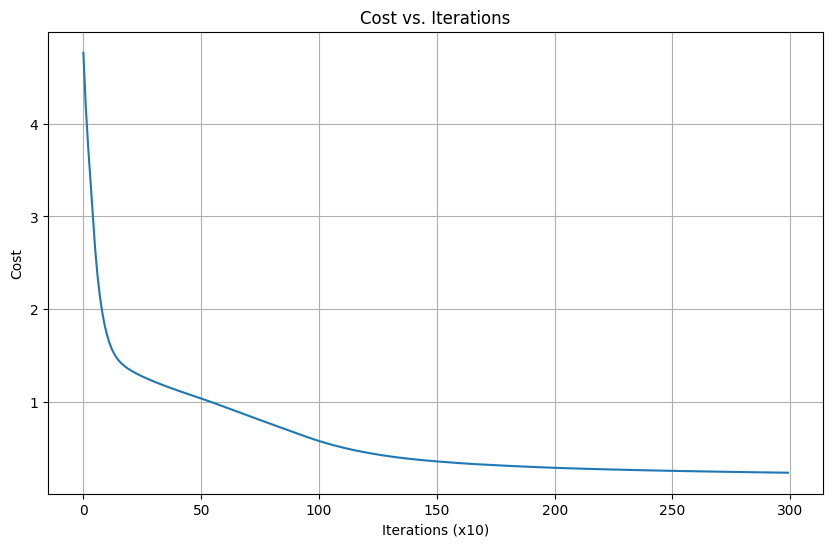

Test MSE: 0.48942986218370743


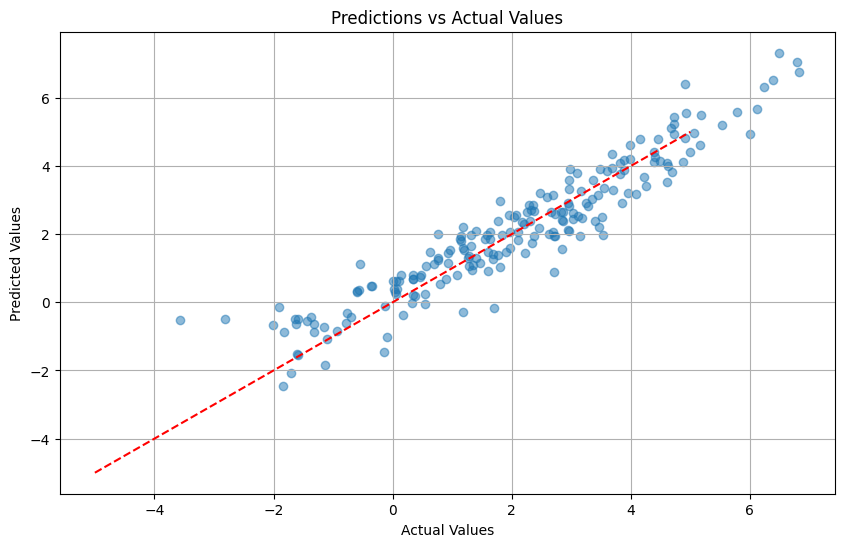

In [4]:
# Define the network architecture: input layer (3 features),
# two hidden layers (10 and 5 neurons), and output layer (1 neuron)
layers_dims = [3, 10, 5, 1]

# Train the neural network
start_time = time.time()
parameters, costs = train_neural_network(
    X_train, y_train,
    layers_dims=layers_dims,
    learning_rate=0.005,
    num_iterations=3000,
    print_cost=True
)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot the cost during training
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.xlabel('Iterations (x10)')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.grid(True)
plt.show()

# Evaluate model on test set
A_test, _ = forward_propagation(X_test, parameters)
test_mse = np.mean(np.square(A_test - y_test.T))
print(f"Test MSE: {test_mse}")

# Visualize predictions vs actual values
y_pred = A_test.T
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

## 4D Visualization

Visualizing our 3-variable function is challenging. We'll create a 3D plot with color as the fourth dimension to represent our function and the model's predictions.

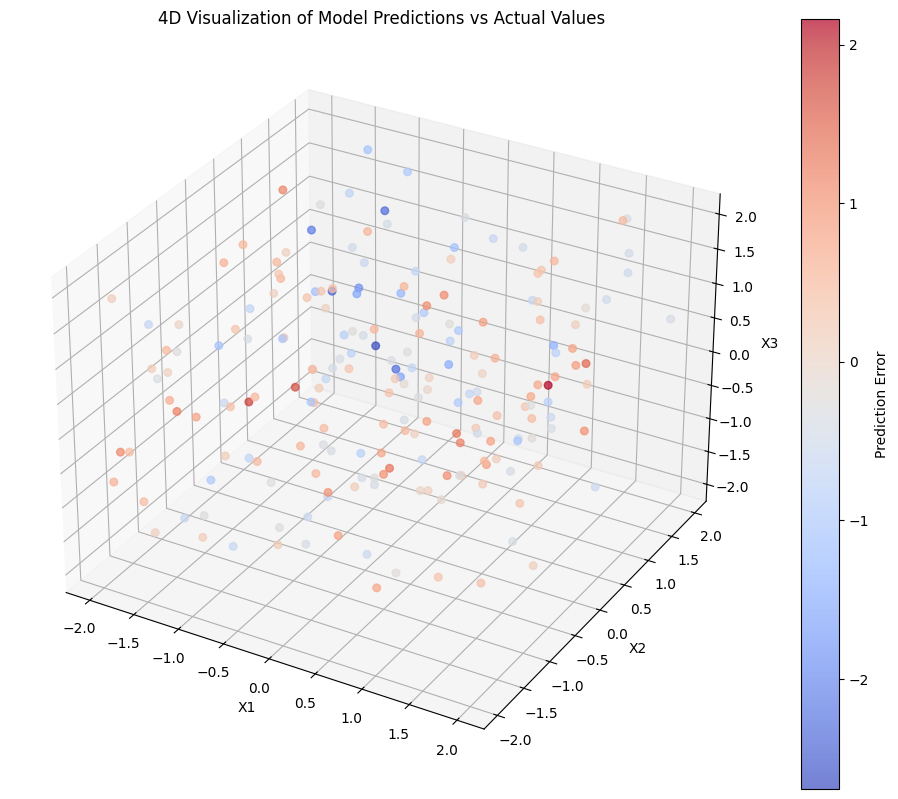

In [6]:
# Create a 4D visualization (3D plot with color as the 4th dimension)
def visualize_4d(X, y_true, y_pred, title):
    # Create a 3D scatter plot with color as the 4th dimension
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate prediction error for coloring
    error = (y_true.flatten() - y_pred.flatten())

    # Create the scatter plot
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2],
                          c=error,  # Use error for coloring
                          cmap=cm.coolwarm,
                          marker='o',
                          alpha=0.7,
                          s=30)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)

    # Show the plot
    plt.show()

# Generate sample data points for visualization
X_vis, y_vis = generate_data(200)
y_vis_pred, _ = forward_propagation(X_vis, parameters)
y_vis_pred = y_vis_pred.T

# Create 4D visualization
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Model Predictions vs Actual Values')

## Alternative Visualization: 2D Slices

Since visualizing a 3-variable function is challenging, we'll also create 2D slice visualizations by fixing one variable and showing how the function changes with respect to the other two variables.

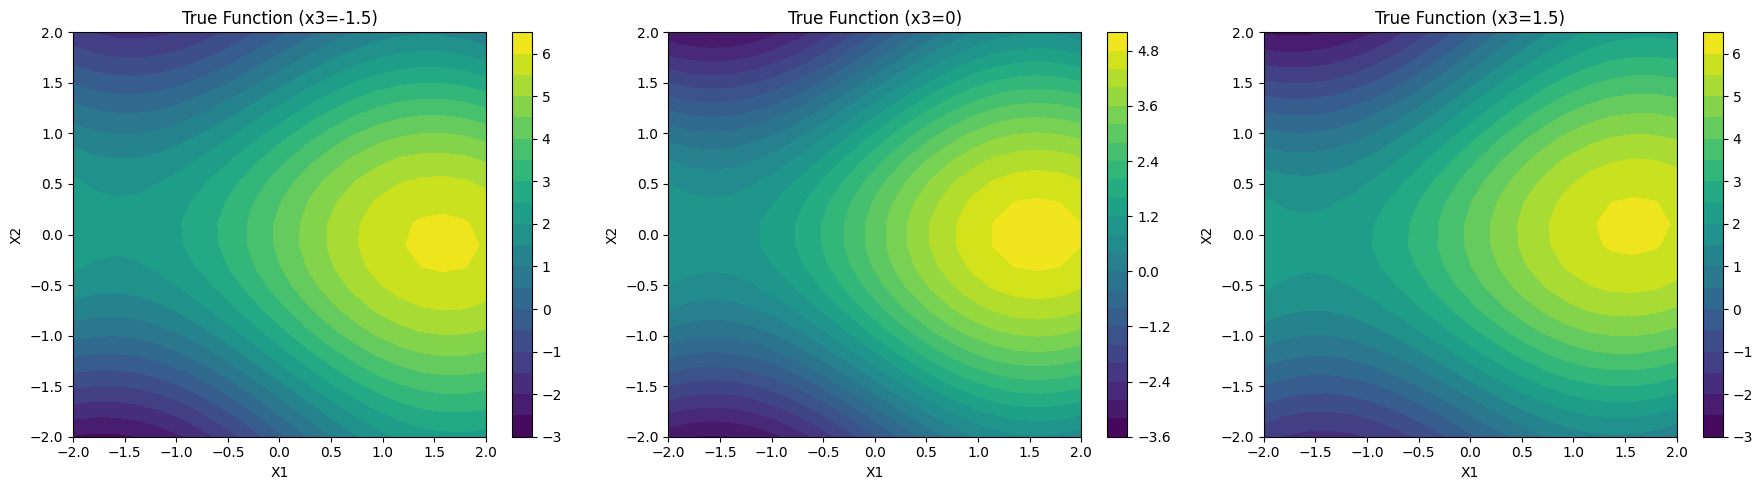

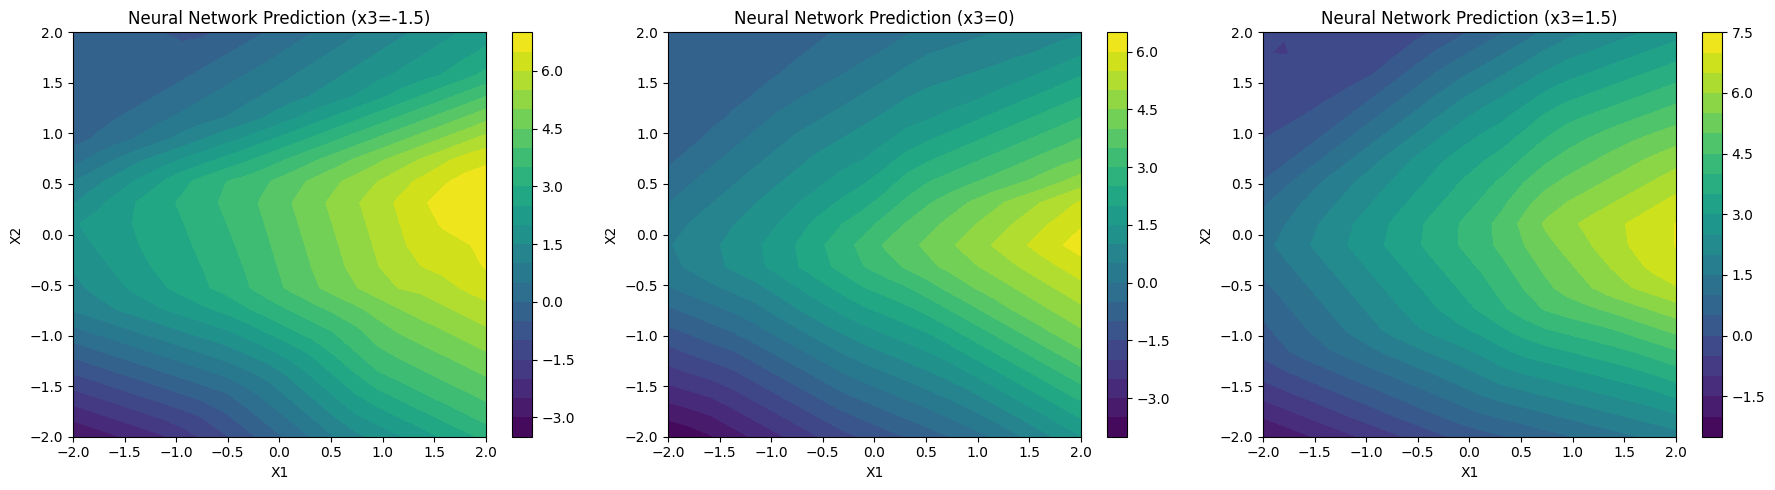

In [7]:
# Alternative visualization with 2D slices
def plot_2d_slices(X_range=2.0, grid_points=20):
    # Create a grid of points for visualization
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]  # Three fixed values for x3

    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input = np.zeros((grid_points*grid_points, 3))
        X_input[:, 0] = X1.flatten()
        X_input[:, 1] = X2.flatten()
        X_input[:, 2] = x3

        # Get true values and predictions
        y_true = true_function(X_input).reshape(grid_points, grid_points)
        y_pred, _ = forward_propagation(X_input, parameters)
        y_pred = y_pred.T.reshape(grid_points, grid_points)

        # Plot the true function
        im1 = axes[i].contourf(X1, X2, y_true, cmap='viridis', levels=20)
        axes[i].set_title(f'True Function (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im1, ax=axes[i])

    plt.tight_layout()
    plt.show()

    # Now plot the predicted function
    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input = np.zeros((grid_points*grid_points, 3))
        X_input[:, 0] = X1.flatten()
        X_input[:, 1] = X2.flatten()
        X_input[:, 2] = x3

        # Get true values and predictions
        y_true = true_function(X_input).reshape(grid_points, grid_points)
        y_pred, _ = forward_propagation(X_input, parameters)
        y_pred = y_pred.T.reshape(grid_points, grid_points)

        # Plot the predicted function
        im2 = axes[i].contourf(X1, X2, y_pred, cmap='viridis', levels=20)
        axes[i].set_title(f'Neural Network Prediction (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im2, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Generate and plot 2D slices
plot_2d_slices(X_range=2.0, grid_points=20)

## Summary

We've successfully implemented a 3-layer neural network from scratch using only NumPy for non-linear regression. Our model:

1. Takes 3 input variables
2. Uses 2 hidden layers with ReLU activation functions
3. Outputs a continuous value prediction
4. Is trained using gradient descent with manual backpropagation

The model has learned to approximate our non-linear 3-variable function with good accuracy. The visualizations show how the predictions compare to the true function, with the error decreasing over training iterations.

Key components implemented:
- Forward propagation
- Backward propagation using the chain rule
- Parameter updates with gradient descent
- Performance evaluation
- Visualization of results